In [1]:
# 在下⾯的代码中，我们实现 dropout_layer 函数，该函数以dropout的概率丢弃张量输⼊X中的元素，如上所述重新缩放剩余部分：将剩余部分除以1.0-dropout
import torch
from torch import nn
from d2l import torch as d2l
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [7]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  6.,  8.,  0., 12., 14.],
        [ 0.,  0., 20., 22.,  0.,  0., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [8]:
# 定义模型参数
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [12]:
# 定义模型
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
        
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使⽤dropout
        if self.training == True:
            # 在第⼀个全连接层之后添加⼀个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第⼆个全连接层之后添加⼀个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

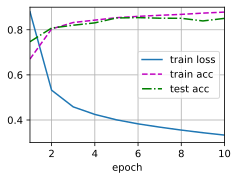

In [13]:
# 训练和测试
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [20]:
# 简介实现
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第⼀个全连接层之后添加⼀个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第⼆个全连接层之后添加⼀个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
                        
net.apply(init_weights);

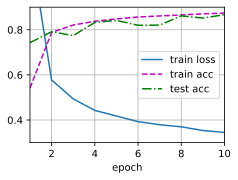

In [21]:
# 训练
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

⼩结<br>
• 暂退法在前向传播过程中，计算每⼀内部层的同时丢弃⼀些神经元。<br>
• 暂退法可以避免过拟合，它通常与控制权重向量的维数和⼤小结合使⽤的。<br>
• 暂退法将活性值h替换为具有期望值h的随机变量。<br>
• 暂退法仅在训练期间使⽤。

练习
1. 如果更改第⼀层和第⼆层的暂退法概率，会发⽣什么情况？具体地说，如果交换这两个层，会发⽣什么情况？设计⼀个实验来回答这些问题，定量描述你的结果，并总结定性的结论。
2. 增加训练轮数，并将使⽤暂退法和不使⽤暂退法时获得的结果进⾏⽐较。
3. 当应⽤或不应⽤暂退法时，每个隐藏层中激活值的⽅差是多少？绘制⼀个曲线图，以显⽰这两个模型的每个隐藏层中激活值的⽅差是如何随时间变化的。
4. 为什么在测试时通常不使⽤暂退法？
5. 以本节中的模型为例，⽐较使⽤暂退法和权重衰减的效果。如果同时使⽤暂退法和权重衰减，会发⽣什么情况？结果是累加的吗？收益是否减少（或者说更糟）？它们互相抵消了吗？
6. 如果我们将暂退法应⽤到权重矩阵的各个权重，而不是激活值，会发⽣什么？
7. 发明另⼀种⽤于在每⼀层注⼊随机噪声的技术，该技术不同于标准的暂退法技术。尝试开发⼀种在Fashion-MNIST数据集（对于固定架构）上性能优于暂退法的⽅法。

1. 做出来的结果，在调换D1和D2层概率后，基本没有什么变化，但是改变第一层和第二层的概率总和后，结果会有明显的变化，猜想是在概率总和一样的情况下，不会对最后的准确率造成太大的影响？（对此我不太敢相信我的结论，希望大家指点）
2. 没有dropout的训练效果会更好，但是泛化性不够好。
4. 因为测试的时候更关注整个模型的泛化度
5. 同时使用效果反而会变差
6. train_loss会下降的比较慢，达不到原本的train_loss。

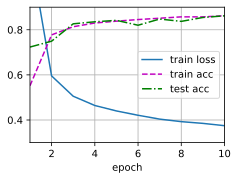

In [22]:
#1.
dropout1, dropout2 = 0.5, 0.2 #交换
# 简介实现
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第⼀个全连接层之后添加⼀个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第⼆个全连接层之后添加⼀个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
                        
net.apply(init_weights);

# 训练
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

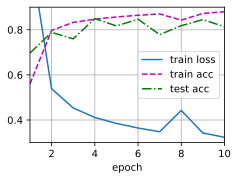

In [27]:
#6.
#from torch.nn.parameter import Parameter

def dropout_weight(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

dropout = 0.5 

# 简介实现
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 10))
def init_weights(m):
    if type(m) == nn.Linear:   
        nn.init.normal_(m.weight, std=0.01)
        # m.weight = dropout_weight(m.weight, dropout) 错误：不能将tensor赋值给线性层权重，应该是parameter才能赋值，或者将tensor赋值给weight.data
        m.weight.data = dropout_weight(m.weight.data, dropout)
        #m.weight = Parameter(dropout_weight(m.weight.data, dropout))

                        
net.apply(init_weights);

# 训练
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)